In [12]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import peak_local_max

%matplotlib inline

In [13]:
def laplacian_of_gaussian(sigma):
    kernel_radius = int(3 * sigma)  # Kernel radius based on sigma
    x_coords, y_coords = np.meshgrid(np.arange(-kernel_radius, kernel_radius + 1), np.arange(-kernel_radius, kernel_radius + 1))

    squared_distances = (x_coords**2 + y_coords**2) / (2 * sigma**2)
    gaussian_term = np.exp(-squared_distances)
    laplacian_term = (squared_distances - 1)

    log_kernel = laplacian_term * gaussian_term / (np.pi * sigma**4)
    return log_kernel


In [14]:
def find_local_maxima(log_image, sigma):
    maxima_coords = []
    height, width = log_image.shape
    offset = 1

    for row in range(offset, height - offset):
        for col in range(offset, width - offset):
            local_patch = log_image[row - offset:row + offset + 1, col - offset:col + offset + 1]
            max_value = np.max(local_patch)  # Find the local maximum

            if max_value >= 0.09:  # Threshold check
                local_max_row, local_max_col = np.unravel_index(np.argmax(local_patch), local_patch.shape)
                maxima_coords.append((row + local_max_row - offset, col + local_max_col - offset))

    return set(maxima_coords)


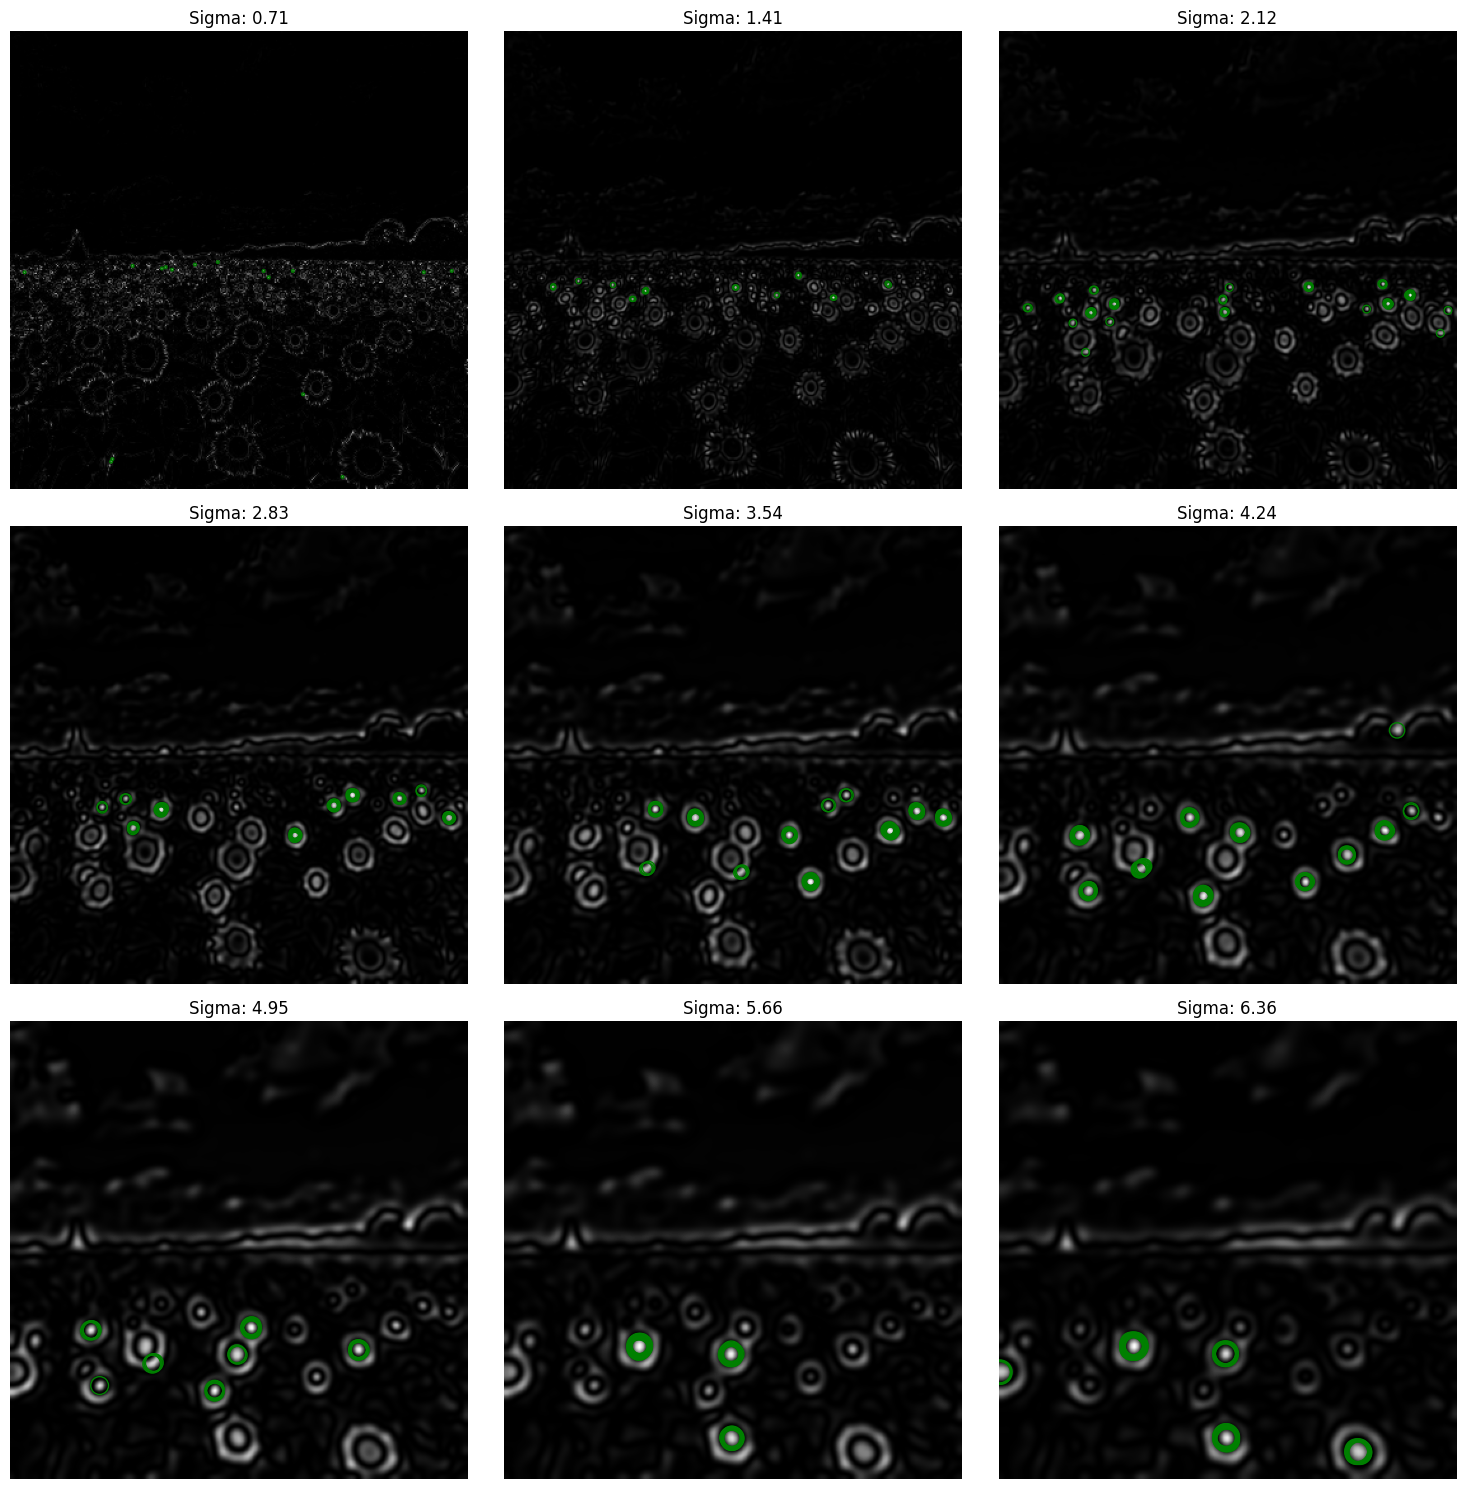

In [15]:
# Load and preprocess the image
image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
grayscale_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) / 255

# Set up the figure for displaying the results
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Loop over different sigma values to find local peaks
for index, axis in enumerate(axes.flatten(), start=1):
    sigma = index / 1.414
    log_kernel = laplacian_of_gaussian(sigma) * sigma**2  # LoG kernel
    log_filtered = np.square(cv.filter2D(grayscale_image, -1, log_kernel))  # Apply LoG filter

    # Find local maxima (coordinates of detected blobs)
    maxima_coordinates = find_local_maxima(log_filtered, sigma)

    # Display the LoG-filtered image
    axis.imshow(log_filtered, cmap='gray')
    axis.set_title(f'Sigma: {sigma:.2f}')

    # Mark detected blobs with circles
    for x, y in maxima_coordinates:
        circle = plt.Circle((y, x), sigma * 1.414, color='green', linewidth=1, fill=False)
        axis.add_patch(circle)
    
    axis.axis('off')  # Turn off axis for better visualization

# Show the figure with all subplots
plt.tight_layout()
plt.show()

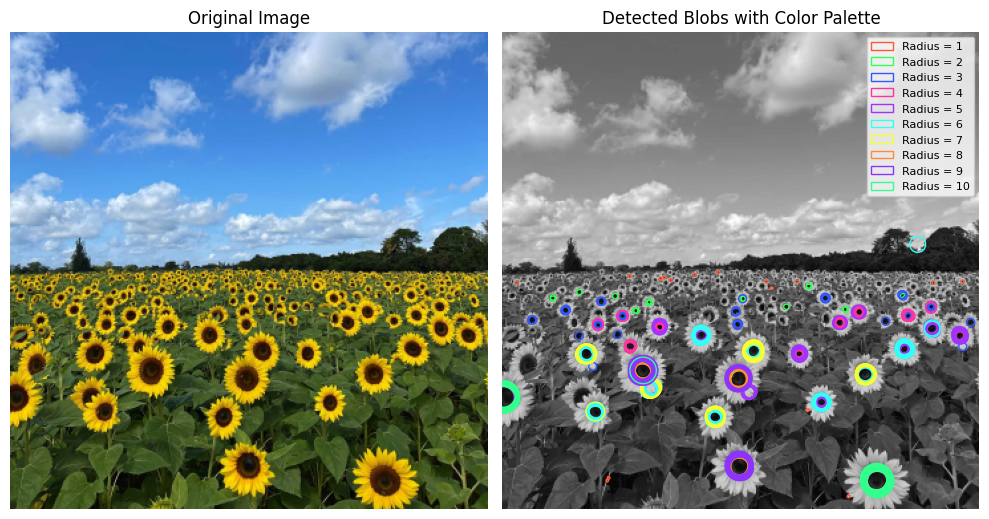

In [16]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image and preprocess it
image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
grayscale_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) / 255

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Show the original image in the first subplot
axes[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Initialize the second subplot
ax = axes[1]
ax.imshow(grayscale_image, cmap='gray')
ax.grid(False)

# Define a new color palette for circles
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#A133FF', '#33FFF5', '#F5FF33', '#FF8C33', '#8C33FF', '#33FF8C']

# Initialize lists for patches and labels
patches = []
labels = []

# Loop over different radius values to detect blobs
for radius in range(1, 11):
    sigma = radius / 1.414
    log_kernel = sigma**2 * laplacian_of_gaussian(sigma)  # Create LoG kernel
    log_filtered = np.square(cv.filter2D(grayscale_image, -1, log_kernel))  # Apply LoG filter

    # Detect maxima (blobs) using the sigma value
    blob_coordinates = find_local_maxima(log_filtered, sigma)

    # Plot detected blobs as circles in different colors
    for x, y in blob_coordinates:
        circle = plt.Circle((y, x), sigma * 1.414, color=colors[radius - 1], linewidth=1, fill=False)
        ax.add_patch(circle)
    
    # Add the current circle as a patch and store label
    patches.append(circle)
    labels.append(f'Radius = {radius}')

# Set limits for x-axis and hide axis in the second subplot
ax.set_xlim(0, image.shape[1])
ax.set_title("Detected Blobs with Color Palette")
ax.legend(patches, labels, loc='best', fontsize=8)

# Remove axis for a cleaner display
ax.axis('off')

# Show the final plot
plt.tight_layout()
plt.show()


<Axes: >

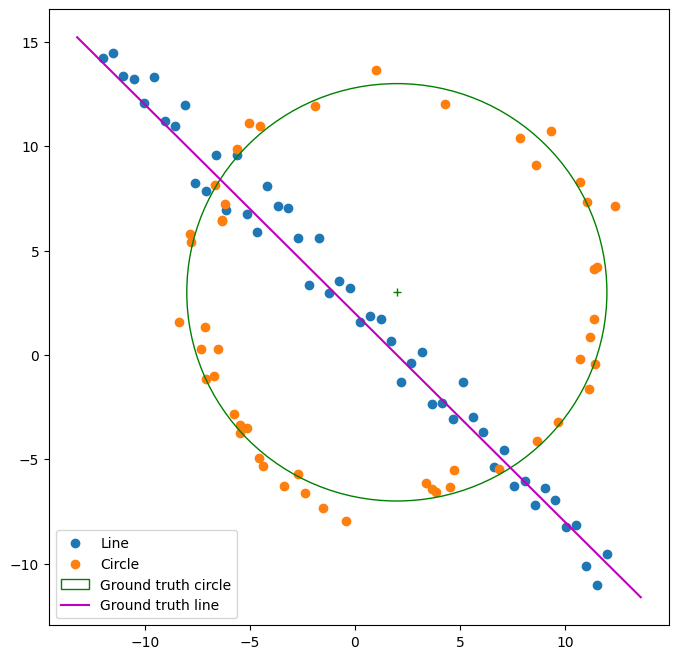

In [17]:
# Generating noisy point set

from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
# import tikzplotlib

# Set random seed
np.random.seed(0)

# Constants
N = 100
half_n = N // 2

# Parameters
r = 10
x0_gt, y0_gt = 2, 3
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s, m, b = 1, -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

# Plotting
def plot_all(separate = True):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if separate:
        ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
        ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
    else:
        ax.scatter(X[:, 0], X[:, 1], label='Point Set')

    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, '+', color='g')

    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = m * x_ + b
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    return ax

plot_all()

In [18]:
def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

def line_eq(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    a = (y2 - y1)
    b = -(x2 - x1)
    d = a*x1 + b*y1
    assert abs(a*x2 + b*y2 - d) < 1e-8

    # Apply constraint
    norm = (a**2 + b**2)**0.5
    a, b, d = a/norm, b/norm, d/norm
    return a, b, d

def circle_eq(p1, p2, p3):
    (x1, y1), (x2, y2), (x3, y3) = p1, p2, p3
    
    # circumcenter of circle is equidistant to all points
    mx1, my1 = (x1 + x2)/2, (y1 + y2)/2
    mx2, my2 = (x1 + x3)/2, (y1 + y3)/2

    s1 = -(x2 - x1)/(y2 - y1)
    s2 = -(x3 - x1)/(y3 - y1)

    c1 = my1 - s1 * mx1
    c2 = my2 - s2 * mx2

    cx = (c2 - c1)/(s1 - s2)
    cy = s1 * cx + c1
    assert abs(s2 * cx + c2 - cy) < 1e-8

    r = dist((cx, cy), p1)
    assert abs(dist((cx, cy), p2) - dist((cx, cy), p1)) < 1e-8
    return cx, cy, r

In [19]:
# Squared error calculation for line and circle
def tls_error_line(params, *args):
    # Error of points denoted by indices, params is the one that should be optimized
    a, b, d = params
    indices, X = args
    error = np.sum((a * X[indices, 0] + b * X[indices, 1] - d)**2)
    return error

def tls_error_circle(params, *args):
    cx, cy, r = params
    indices, X = args
    error = np.sum((dist((cx, cy), (X[indices, 0], X[indices, 1])) - r)**2)
    return error

In [20]:
def consensus_line(params, thres, X):   # Whether each point is an inlier
    a, b, d = params
    errors = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return np.where(errors < thres)

def consensus_circle(params, thres, X):   # Whether each point is an inlier
    cx, cy, r = params
    errors = np.abs(dist((cx, cy), (X[:, 0], X[:, 1])) - r) # radial error
    return np.where(errors < thres)

def constraint(params): # Should be equal to zero
    a, b, d = params
    return (a**2 + b**2)**0.5 - 1

constraint_dict = {'type':'eq', 'fun':constraint}

def least_squares_line_fit(indices, initial, X):  # line fitting with scipy minimize
    res = minimize(fun=tls_error_line, x0=initial, args=(indices, X), constraints=constraint_dict, tol=1e-6)
    print(res.x, res.fun)
    return res

def least_squares_circ_fit(indices, initial, X):
    res = minimize(fun=tls_error_circle, x0=initial, args=(indices, X), tol=1e-6)
    print(res.x, res.fun)
    return res

In [21]:
# Fitting the line

iters = 100
min_points = 2
N = X.shape[0]
np.random.seed(14)

thres = 1.   # Error threshold for selecting inliers
d = 0.4 * N # Minimum inlier count for a good fit

best_model_line = None
best_fitted_line = None
best_error = np.inf
best_line_inliers = None
best_line_sample_points = None

for i in range(iters):
    indices = np.random.choice(np.arange(0, N), size=min_points, replace=False)
    params = line_eq(X[indices[0]], X[indices[1]])
    inliers = consensus_line(params, thres, X)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    if len(inliers) >= d:   # compute again 
        res = least_squares_line_fit(inliers, params, X)
        if res.fun < best_error:
            best_error = res.fun
            best_model_line = params
            best_fitted_line = res.x
            best_line_inliers = inliers
            best_sample_points = indices

line_inliers = consensus_line(best_fitted_line, 1.2, X)[0]

print(f'Best line = {best_fitted_line}, No. of inliers = {len(line_inliers)}, best_error = {best_error}')
    

Iteration 0: No. of inliers = 9
Iteration 1: No. of inliers = 34
Iteration 2: No. of inliers = 4
Iteration 3: No. of inliers = 16
Iteration 4: No. of inliers = 6
Iteration 5: No. of inliers = 12
Iteration 6: No. of inliers = 11
Iteration 7: No. of inliers = 8
Iteration 8: No. of inliers = 12
Iteration 9: No. of inliers = 15
Iteration 10: No. of inliers = 5
Iteration 11: No. of inliers = 8
Iteration 12: No. of inliers = 37
Iteration 13: No. of inliers = 12
Iteration 14: No. of inliers = 21
Iteration 15: No. of inliers = 8
Iteration 16: No. of inliers = 10
Iteration 17: No. of inliers = 16
Iteration 18: No. of inliers = 12
Iteration 19: No. of inliers = 23
Iteration 20: No. of inliers = 29
Iteration 21: No. of inliers = 6
Iteration 22: No. of inliers = 39
Iteration 23: No. of inliers = 38
Iteration 24: No. of inliers = 10
Iteration 25: No. of inliers = 4
Iteration 26: No. of inliers = 22
Iteration 27: No. of inliers = 40
[0.71205467 0.70212402 1.53281698] 8.09865025050975
Iteration 28: N

In [22]:
# fitting the circle

remaining_points = np.array([i for i in range(N) if i not in line_inliers])
X_rem = X[remaining_points]

iters = 100
min_points = 3  # We need 3 points to estimate a circle

thres = 1.2   # Error threshold for selecting inliers
d = 0.4 * N # Minimum inlier count for a good fit

best_model_circle = None
best_fitted_circle = None
best_error = np.inf
best_circ_inliers = None
best_circ_sample_points = None

for i in range(iters):
    indices = np.random.choice(np.arange(len(X_rem)), size=min_points, replace=False)
    params = circle_eq(*X_rem[indices])
    inliers = consensus_circle(params, thres, X_rem)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    if len(inliers) >= d:   # compute again 
        res = least_squares_circ_fit(inliers, params, X_rem)
        if res.fun < best_error:
            best_error = res.fun
            best_model_circle = params
            best_fitted_circle = res.x
            best_circ_inliers = inliers
            best_circ_sample_points = indices

circ_inliers = consensus_circle(best_fitted_circle, thres, X_rem)[0]

print(f'Best circle = {best_fitted_circle}, No. of inliers = {len(circ_inliers)}, best_error = {best_error}')

Iteration 0: No. of inliers = 10
Iteration 1: No. of inliers = 12
Iteration 2: No. of inliers = 10
Iteration 3: No. of inliers = 41
[1.8828232  3.18299016 9.81978826] 8.709305494445344
Iteration 4: No. of inliers = 34
Iteration 5: No. of inliers = 5
Iteration 6: No. of inliers = 25
Iteration 7: No. of inliers = 21
Iteration 8: No. of inliers = 30
Iteration 9: No. of inliers = 41
[1.69665199 3.00402845 9.92790141] 9.203751651287867
Iteration 10: No. of inliers = 37
Iteration 11: No. of inliers = 17
Iteration 12: No. of inliers = 25
Iteration 13: No. of inliers = 35
Iteration 14: No. of inliers = 11
Iteration 15: No. of inliers = 44
[1.81818057 3.07505684 9.97826825] 12.835201704007074
Iteration 16: No. of inliers = 8
Iteration 17: No. of inliers = 18
Iteration 18: No. of inliers = 39
Iteration 19: No. of inliers = 28
Iteration 20: No. of inliers = 14
Iteration 21: No. of inliers = 10
Iteration 22: No. of inliers = 34
Iteration 23: No. of inliers = 28
Iteration 24: No. of inliers = 41
[1

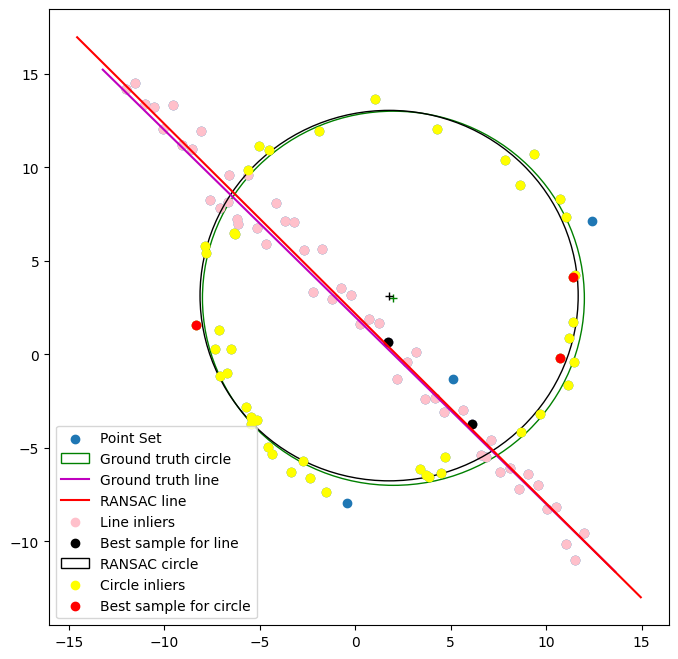

In [23]:
ax = plot_all(False)

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
A, B, D = best_fitted_line
indices = line_inliers

y_ = (D - A*x_) / B
plt.plot(x_, y_, color='r', label='RANSAC line')
ax.scatter(X[indices, 0], X[indices, 1], color = 'pink', label = "Line inliers")
ax.scatter(X[best_sample_points, 0], X[best_sample_points, 1], color = 'black', label = "Best sample for line")

x0, y0, r0 = best_fitted_circle
circle_gt = plt.Circle((x0, y0), r0, color='black', fill=False, label='RANSAC circle')
ax.add_patch(circle_gt)
ax.plot(x0, y0, '+', color='black')

ax.scatter(X_rem[circ_inliers, 0], X_rem[circ_inliers, 1], color = 'yellow', label = "Circle inliers")
ax.scatter(X_rem[best_circ_sample_points, 0], X_rem[best_circ_sample_points, 1], color = 'red', label = "Best sample for circle")

plt.legend()

In [55]:
import numpy as np
import cv2 as cv
from skimage import transform

# Load the images
im1 = cv.imread('005.jpg')
im2 = cv.imread('flag.png')
assert im1 is not None and im2 is not None, "Error loading images"

# Number of points to select
N = 4
selected_points = np.empty((N, 2), dtype=np.float32)
current_point = 0

# Callback function to handle mouse events
def select_points(event, x, y, flags, param):
    global current_point
    if event == cv.EVENT_LBUTTONDOWN and current_point < N:
        cv.circle(param, (x, y), 5, (0, 255, 0), -1)
        selected_points[current_point] = (x, y)
        current_point += 1

# Make a copy of the image to draw on
im1_copy = im1.copy()

# Set up the window and callback
cv.namedWindow('Image 1', cv.WINDOW_AUTOSIZE)
cv.setMouseCallback('Image 1', select_points, im1_copy)

# Event loop to display the image and capture points
while current_point < N:
    cv.imshow('Image 1', im1_copy)
    if cv.waitKey(20) & 0xFF == 27:  # Exit on 'Esc' key
        break

cv.destroyAllWindows()

# Print the selected points
dst_points = selected_points
print("Selected points:", dst_points)


Selected points: [[464. 303.]
 [458. 549.]
 [877. 550.]
 [856. 272.]]


In [53]:
def superimpose(image, logo, dst_points, beta=0.3, alpha=1):
    # Get the dimensions of the logo
    logo_height, logo_width, _ = logo.shape
    dst_height, dst_width, _ = image.shape

    # Define source points for the logo (corners)
    src_points = np.array([[0, logo_height], [logo_width, logo_height], [logo_width, 0], [0, 0]])

    # Pad the logo vertically if it is shorter than the image height
    if logo_height < dst_height:
        logo = np.pad(logo, ((0, dst_height - logo_height), (0, 0), (0, 0)), mode='constant')

    # Pad the logo horizontally if it is narrower than the image width
    if logo_width < dst_width:
        logo = np.pad(logo, ((0, 0), (0, dst_width - logo_width), (0, 0)), mode='constant')

    # Estimate projective transform between source and destination points
    tform = transform.estimate_transform('projective', src_points, dst_points)

    # Warp the logo to fit the destination points
    warped_logo = transform.warp(logo, tform.inverse, output_shape=(dst_height, dst_width))
    warped_logo = (warped_logo * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

    # Clip the transformed logo if it exceeds the size of the destination image
    if warped_logo.shape[0] > dst_height:
        warped_logo = warped_logo[:dst_height, :]
    if warped_logo.shape[1] > dst_width:
        warped_logo = warped_logo[:, :dst_width]

    # Blend the warped logo with the original image using the specified alpha and beta values
    blended_image = cv.addWeighted(image, alpha, warped_logo, beta, 0)

    return blended_image

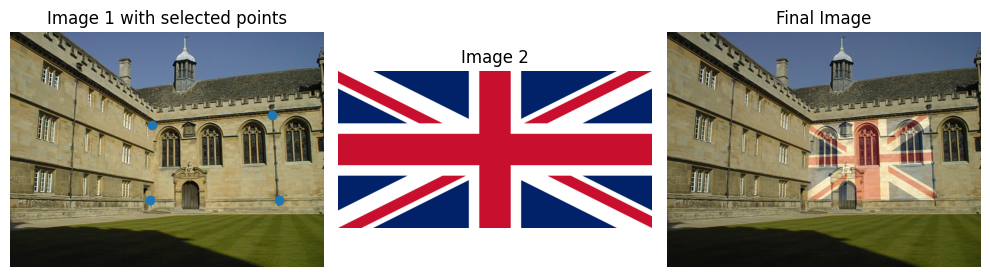

In [56]:
dst = superimpose(im1, im2, dst_points, 0.3, 0.9)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(im1, cv.COLOR_RGB2BGR))
plt.scatter(dst_points[:, 0], dst_points[:, 1])
plt.title("Image 1 with selected points")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv.cvtColor(im2, cv.COLOR_RGB2BGR))
plt.title("Image 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(dst, cv.COLOR_RGB2BGR))
plt.title("Final Image")
plt.axis('off')

plt.tight_layout()

Selected points: [[ 50. 344.]
 [331. 362.]
 [309. 112.]
 [120.  53.]]


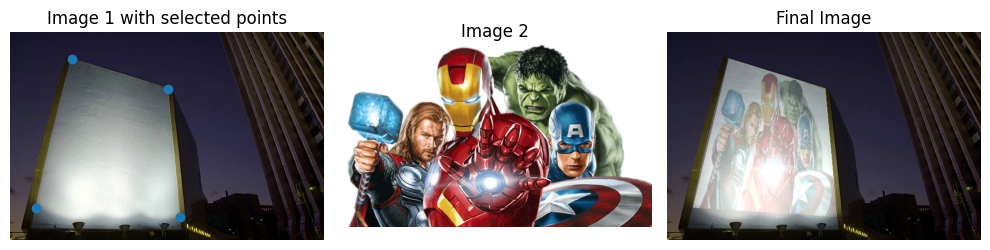

In [72]:
import numpy as np
import cv2 as cv
from skimage import transform

# Load the images
im1 = cv.imread('wallPic.jpg')
im2 = cv.imread('Marvel-Avengers-PNG-Pic.png')
assert im1 is not None and im2 is not None, "Error loading images"

# Number of points to select
N = 4
selected_points = np.empty((N, 2), dtype=np.float32)
current_point = 0

# Callback function to handle mouse events
def select_points(event, x, y, flags, param):
    global current_point
    if event == cv.EVENT_LBUTTONDOWN and current_point < N:
        cv.circle(param, (x, y), 5, (0, 255, 0), -1)
        selected_points[current_point] = (x, y)
        current_point += 1

# Make a copy of the image to draw on
im1_copy = im1.copy()

# Set up the window and callback
cv.namedWindow('Image 1', cv.WINDOW_AUTOSIZE)
cv.setMouseCallback('Image 1', select_points, im1_copy)

# Event loop to display the image and capture points
while current_point < N:
    cv.imshow('Image 1', im1_copy)
    if cv.waitKey(20) & 0xFF == 27:  # Exit on 'Esc' key
        break

cv.destroyAllWindows()

# Print the selected points
dst_points = selected_points
print("Selected points:", dst_points)

dst = superimpose(im1, im2, dst_points, 0.3, 0.9)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(im1, cv.COLOR_RGB2BGR))
plt.scatter(dst_points[:, 0], dst_points[:, 1])
plt.title("Image 1 with selected points")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv.cvtColor(im2, cv.COLOR_RGB2BGR))
plt.title("Image 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(dst, cv.COLOR_RGB2BGR))
plt.title("Final Image")
plt.axis('off')

plt.tight_layout()

In [88]:
import numpy as np
import cv2 as cv
from skimage import transform

# Load the images
im1 = cv.imread('big bill board.jpg')
im2 = cv.imread('uom_banner.png')
assert im1 is not None and im2 is not None, "Error loading images"

# Number of points to select
N = 4
selected_points = np.empty((N, 2), dtype=np.float32)
current_point = 0

# Callback function to handle mouse events
def select_points(event, x, y, flags, param):
    global current_point
    if event == cv.EVENT_LBUTTONDOWN and current_point < N:
        cv.circle(param, (x, y), 5, (0, 255, 0), -1)
        selected_points[current_point] = (x, y)
        current_point += 1

# Make a copy of the image to draw on
im1_copy = im1.copy()

# Set up the window and callback
cv.namedWindow('Image 1', cv.WINDOW_AUTOSIZE)
cv.setMouseCallback('Image 1', select_points, im1_copy)

# Event loop to display the image and capture points
while current_point < N:
    cv.imshow('Image 1', im1_copy)
    if cv.waitKey(20) & 0xFF == 27:  # Exit on 'Esc' key
        break

cv.destroyAllWindows()

# Print the selected points
dst_points = selected_points
print("Selected points:", dst_points)



Selected points: [[183. 222.]
 [476. 258.]
 [474. 199.]
 [189.  91.]]


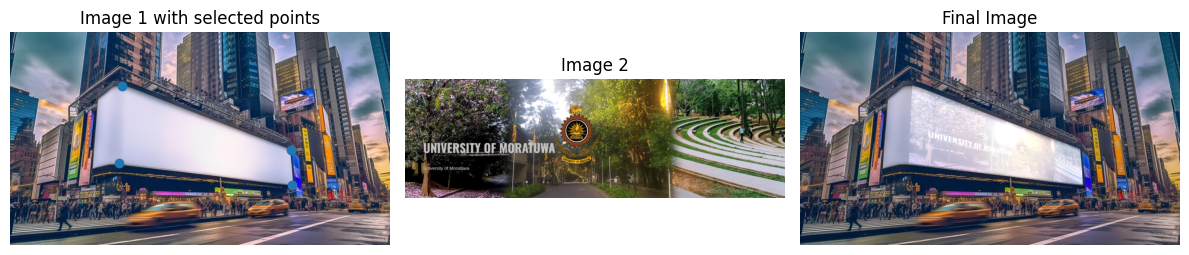

In [89]:
dst = superimpose(im1, im2, dst_points, 0.3, 0.9)

plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(im1, cv.COLOR_RGB2BGR))
plt.scatter(dst_points[:, 0], dst_points[:, 1])
plt.title("Image 1 with selected points")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv.cvtColor(im2, cv.COLOR_RGB2BGR))
plt.title("Image 2")
plt.axis('off')

plt.subplot(1,3, 3)
plt.imshow(cv.cvtColor(dst, cv.COLOR_RGB2BGR))
plt.title("Final Image")
plt.axis('off')

plt.tight_layout()

## Question 4

In [94]:
import numpy as np
import cv2 as cv
from skimage import transform
import matplotlib.pyplot as plt

def sift_features(image1, image5, plot=False):
    # Convert images to grayscale
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image5_gray = cv.cvtColor(image5, cv.COLOR_RGB2GRAY)

    # Initialize SIFT detector
    sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=25, sigma=1)

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1_gray, None)
    keypoints5, descriptors5 = sift.detectAndCompute(image5_gray, None)

    # Use Brute Force matcher for feature matching
    bf_matcher = cv.BFMatcher()
    matches = bf_matcher.knnMatch(descriptors1, descriptors5, k=2)

    # Apply ratio test for filtering good matches
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    if plot:
        # Plot the keypoints and matches
        plot_sift_features(image1_gray, keypoints1, image5_gray, keypoints5, good_matches)

    return good_matches, keypoints1, keypoints5


def plot_sift_features(image1_gray, keypoints1, image5_gray, keypoints5, good_matches):
    plt.figure()
    
    # Plot keypoints of image1
    plt.subplot(1, 2, 1)
    image1_features = cv.drawKeypoints(image1_gray, keypoints1, None)
    plt.imshow(image1_features)
    plt.title("Image 1 SIFT features")
    plt.axis('off')

    # Plot keypoints of image5
    plt.subplot(1, 2, 2)
    image5_features = cv.drawKeypoints(image5_gray, keypoints5, None)
    plt.imshow(image5_features)
    plt.title("Image 5 SIFT features")
    plt.axis('off')

    # Plot matched features
    plt.figure()
    matched_img = cv.drawMatches(image1_gray, keypoints1, image5_gray, keypoints5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(matched_img)
    plt.title("Matched features between Image 1 and 5")
    plt.axis('off')
    plt.show()


In [95]:
def get_inliers(src_points, dst_points, tform, threshold):
    transformed_points = tform(src_points)
    errors = np.sqrt(np.sum((transformed_points - dst_points) ** 2, axis=1))
    return np.where(errors < threshold)[0]


In [96]:
def find_best_homography(good_matches, keypoints1, keypoints5):
    src_full = np.array([keypoints1[m.queryIdx].pt for m in good_matches])
    dst_full = np.array([keypoints5[m.trainIdx].pt for m in good_matches])

    num_points = 4
    threshold = 1
    min_inliers = 0.5 * len(good_matches)
    iterations = 200

    best_homography = None
    best_inlier_count = 0
    best_inliers = None

    for _ in range(iterations):
        selected_matches = np.random.choice(good_matches, num_points, replace=False)
        
        src_points = np.array([keypoints1[m.queryIdx].pt for m in selected_matches])
        dst_points = np.array([keypoints5[m.trainIdx].pt for m in selected_matches])

        tform = transform.estimate_transform('projective', src_points, dst_points)
        inliers = get_inliers(src_full, dst_full, tform, threshold)

        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_homography = tform
            best_inliers = inliers

    print(f'Best number of inliers: {best_inlier_count}')
    return best_homography, best_inliers


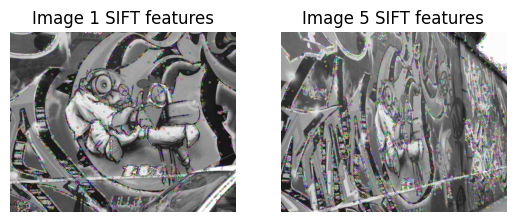

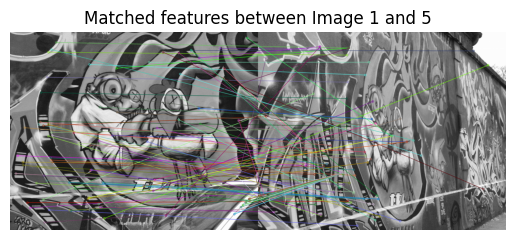

Best number of inliers: 22


In [107]:
# Load the images
image1 = cv.imread("graf/img1.ppm")
image5 = cv.imread("graf/img5.ppm")

# Convert images to RGB
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image5 = cv.cvtColor(image5, cv.COLOR_BGR2RGB)

# Detect and match SIFT features
good_matches, keypoints1, keypoints5 = sift_features(image1, image5, plot=True)

# Find the best homography using RANSAC
best_homography, best_inliers = find_best_homography(good_matches, keypoints1, keypoints5)



Best number of inliers: 734
Best number of inliers: 544
Best number of inliers: 695
Best number of inliers: 493


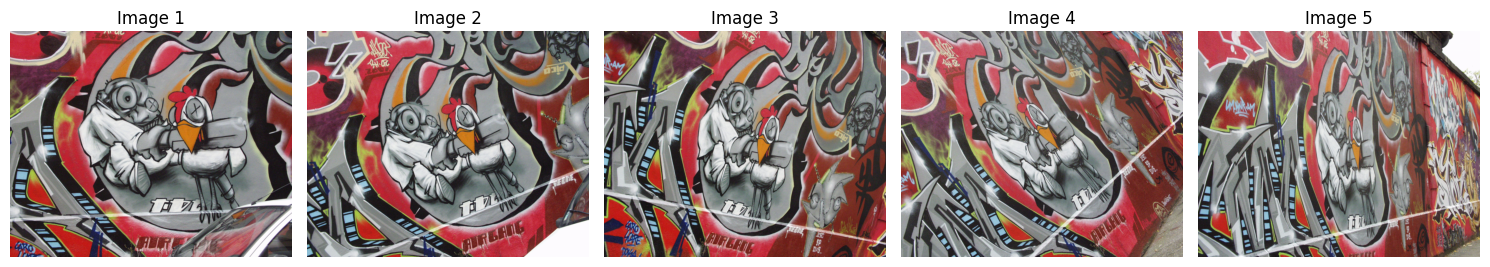

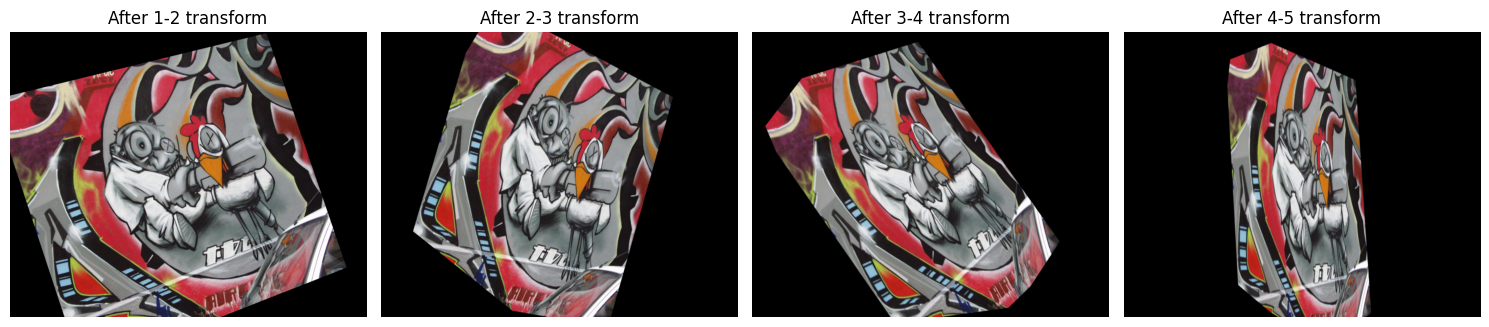

In [111]:
# Set random seed and padding value
np.random.seed(62)
pad = 100

# Load and display the images
def load_and_display_images(num_images=5):
    images = []
    plt.figure(figsize=(15, 10))
    
    for i in range(1, num_images + 1):
        img = cv.imread(f"graf/img{i}.ppm")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        images.append(img)

        # Display images
        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.title(f"Image {i}")
        plt.axis('off')
    
    plt.tight_layout()
    return images

final_transform = transform.ProjectiveTransform(np.identity(3))

# Stitch images using SIFT and homography
def stitch_images(images):
    global final_transform  # Declare final_transform as global

    final_transformed_image = images[0]  # Initialize with the first image

    plt.figure(figsize=(15, 10))
    
    for i in range(1, len(images)):
        img1, img2 = images[i-1], images[i]

        # Get SIFT features and find the best homography
        good_matches, keypoints1, keypoints2 = sift_features(img1, img2)
        tform, _ = find_best_homography(good_matches, keypoints1, keypoints2)

        # Apply the transformation
        final_transformed_image = transform.warp(final_transformed_image, tform.inverse)

        # Accumulate transformations
        final_transform = final_transform + tform

        # Display intermediate results
        plt.subplot(1, len(images) - 1, i)
        plt.imshow(final_transformed_image)
        plt.title(f"After {i}-{i+1} transform")
        plt.axis('off')

    plt.tight_layout()
    
    # Final warp of the first image with the accumulated transformation
    return transform.warp(images[0], final_transform.inverse)

# Load images
images = load_and_display_images()

# Perform stitching and display intermediate transformations
final_transformed_image = stitch_images(images)

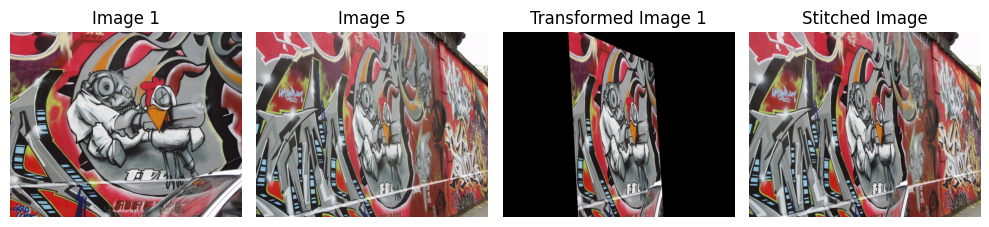

In [112]:
final_transformed_image = transform.warp(images[0], final_transform.inverse)
final_transformed_image = (final_transformed_image * 255).astype(np.uint8)
mask = (final_transformed_image == 0)
stitched_image = mask * images[4] + final_transformed_image

plt.figure(figsize = (10, 10))

plt.subplot(1, 4, 1)
plt.imshow(images[0])
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(images[4])
plt.title("Image 5")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(final_transformed_image)
plt.title("Transformed Image 1")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(stitched_image)
plt.title("Stitched Image")
plt.axis('off')
plt.tight_layout()

In [113]:
actual_tform = np.array([[6.2544644e-01, 5.7759174e-02, 2.2201217e+02],
                         [2.2240536e-01, 1.1652147e+00, -2.5605611e+01],
                         [4.9212545e-04, -3.6542424e-05, 1.0000000e+00]])

print("Computed Homography:")
print(final_transform.params)
print("\nActual Homography:")
print(actual_tform)
print("\nSum of squared errors:", np.sum(np.square(actual_tform - best_homography.params)))


Computed Homography:
[[ 6.11404459e-01  5.03189502e-02  2.21391678e+02]
 [ 2.11980223e-01  1.14096503e+00 -2.14952739e+01]
 [ 4.74861344e-04 -5.18621014e-05  9.90604809e-01]]

Actual Homography:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]

Sum of squared errors: 233525.3846370272
